# Kaggle Project: Identifying Profitable Trades using XGBoost

The efficient market hypothesis posits that markets cannot be beaten because asset prices will always reflect the fundamental value of the assets. In a perfectly efficient market, buyers and sellers would have all the agency and information needed to make rational trading decisions. 

In reality, financial markets are not efficient. The purpose of this trading model is to identify arbitrage opportunities to "buy low and sell high". In other words, we exploit market inefficiencies to identify and decide whether to execute profitable trades.

The dataset, provided by Jane Street, contains an anonymized set of 129 features representing real stock market data. Each row in the dataset represents a trading opportunity, for which I predict an action value: 1 to make the trade and 0 to pass on it. I use XGBoost (extreme gradient boosting) - a hugely popular ML library due to its superior execution speed and model performance - to predict profitable trades. I also use Optuna (an automatic hyperparameter optimization software framework) to tune the hyperparameters of the classification model.

*Due to the high dimensionality of the dataset, I initially wanted to use Principal Components Analysis (PCA) to identify features to be used for supervised learning. The intuition is to compress the dataset and use it more efficiently. However, I realised that the performance of the model worsens significantly with PCA.

Please upvote if you find this notebook helpful! 😊 Thank you! I would also be very happy to receive feedback on my work.

# 1) Import important libraries and packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import optuna

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


# 2) Load and clean dataset

In [2]:
# Import dataset as train
train = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv', nrows=1800000)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.1 MB


In [3]:
# Drop rows with 'weight'=0 
# Trades with weight = 0 were intentionally included in the dataset for completeness, 
# although such trades will not contribute towards the scoring evaluation
train = train[train['weight']!=0]

# Create 'action' column (dependent variable)
# The 'action' column is defined as such because of the evaluation metric used for this project.
# We want to maximise the utility function and hence pi where pi=∑j(weightij∗respij∗actionij)
# Positive values of resp will increase pi
train['action'] = train['resp'].apply(lambda x:x>0).astype(int)

In [4]:
features = [col for col in list(train.columns) if 'feature' in col]

In [5]:
X = train[features]
y = train['action']

# Next, we hold out part of the training data to form the hold-out validation set
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2)

# 3) Exploratory data analysis

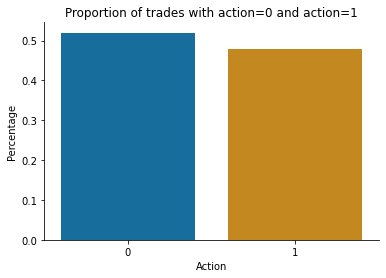

In [6]:
# First, we want to check if the target class is balanced or unbalanced in the training data
sns.set_palette("colorblind")
ax = sns.barplot(train_y.value_counts().index, train_y.value_counts()/len(train_y))
ax.set_title("Proportion of trades with action=0 and action=1")
ax.set_ylabel("Percentage")
ax.set_xlabel("Action")
sns.despine();
# Target class is fairly balanced with almost 50% of trades corresponding to each action

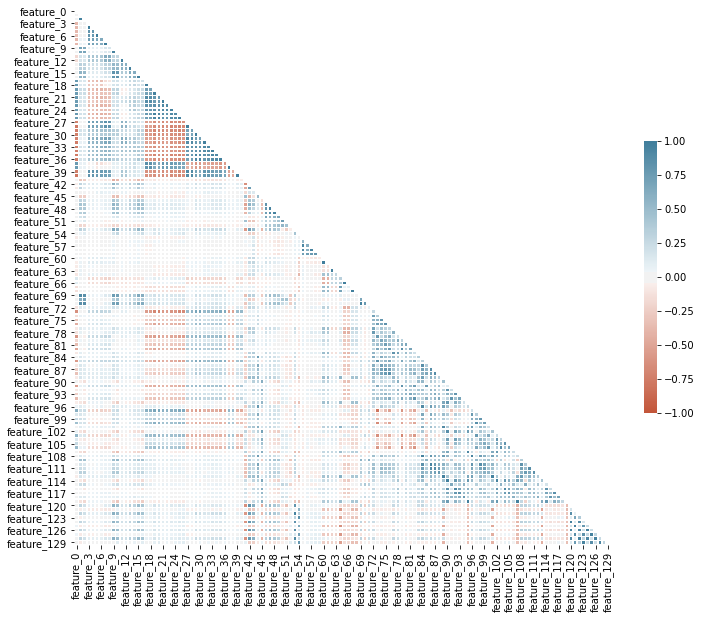

In [7]:
# Next, we plot a diagonal correlation heatmap to see if there are strong correlations between the features

# Compute the correlation matrix
corr = train_x.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# There are strong correlations between several of the features

In [8]:
# Finally, we investigate if there are missing values and we impute them
missing_values = pd.DataFrame()
missing_values['feature'] = features
missing_values['num_missing'] = [train_x[i].isna().sum() for i in features]
missing_values.T
# There are quite a lot of missing values across the features

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
feature,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
num_missing,0,0,0,0,0,0,0,347,347,0,...,92,92,0,0,0,0,0,0,0,0


In [9]:
train_median = train_x.median()
# Impute medians in both training set and the hold-out validation set
train_x = train_x.fillna(train_median)
valid_x = valid_x.fillna(train_median)

# 4) Principal Components Analysis
-- RETIRED section: I realised that PCA helps to reduce the dimensionality of my dataset and speeds up the time my code takes to run. However, the performance of the XGBoost model suffers significantly with dimension reduction.

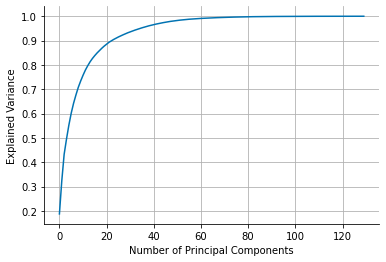

In [10]:
# Before we perform PCA, we need to normalise the features so that they have zero mean and unit variance
scaler = StandardScaler()
scaler.fit(train_x)
train_x_norm = scaler.transform(train_x)

pca = PCA()
comp = pca.fit(train_x_norm)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();

# The first 15 principal components explains about 80% of the variation
# The first 40 principal components explains about 95% of the variation

In [11]:
# Using the first 40 principal components, we apply the PCA mapping
# From here on, we work with only 40 features instead of the full set of 129 features
pca = PCA(n_components=40).fit(train_x_norm)
train_x_transform = pca.transform(train_x_norm)

In [12]:
# Transform the validation set
valid_x_transform = pca.transform(scaler.transform(valid_x))

# 5) Train XGBoost classifier + Tune hyperparameters using Optuna

In [35]:
# We create the XGboost-specific DMatrix data format from the numpy array. 
# This data structure is optimised for memory efficiency and training speed
dtrain = xgb.DMatrix(train_x.values, label=train_y)
dvalid = xgb.DMatrix(valid_x.values, label=valid_y)

In [36]:
# The objective function is passed an Optuna specific argument of trial
def objective(trial):
    
# params specifies the XGBoost hyperparameters to be tuned
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 750),
        'max_depth': trial.suggest_int('max_depth', 18, 25),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.80, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 20),
        'tree_method': 'gpu_hist',  
        'objective': 'binary:logistic'
    }
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
# trials will be evaluated based on their accuracy on the test set
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [37]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-01-04 18:05:57,320] A new study created in memory with name: no-name-b0ba5238-e52a-47eb-be6b-ee6dda5588e8


[18:05:57] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:05:59,442] Trial 0 finished with value: 0.5794392523364486 and parameters: {'n_estimators': 677, 'max_depth': 25, 'learning_rate': 0.09641797883077788, 'subsample': 0.894992971244735, 'colsample_bytree': 0.6130541020723381, 'gamma': 15}. Best is trial 0 with value: 0.5794392523364486.


[18:05:59] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:00,480] Trial 1 finished with value: 0.5950155763239875 and parameters: {'n_estimators': 657, 'max_depth': 24, 'learning_rate': 0.06404218397369814, 'subsample': 0.9762792574707136, 'colsample_bytree': 0.6948655895185666, 'gamma': 13}. Best is trial 1 with value: 0.5950155763239875.
[I 2021-01-04 18:06:00,559] Trial 2 finished with value: 0.6573208722741433 and parameters: {'n_estimators': 612, 'max_depth': 19, 'learning_rate': 0.09318297183717975, 'subsample': 0.8883809058684135, 'colsample_bytree': 0.6664243778990147, 'gamma': 7}. Best is trial 2 with value: 0.6573208722741433.


[18:06:00] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:00] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:00,756] Trial 3 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 718, 'max_depth': 20, 'learning_rate': 0.054851237359831, 'subsample': 0.8298629435613815, 'colsample_bytree': 0.792839213729811, 'gamma': 3}. Best is trial 3 with value: 0.6666666666666666.
[I 2021-01-04 18:06:00,831] Trial 4 finished with value: 0.6137071651090342 and parameters: {'n_estimators': 624, 'max_depth': 20, 'learning_rate': 0.050215395897892146, 'subsample': 0.8751514337684063, 'colsample_bytree': 0.9779010047447751, 'gamma': 16}. Best is trial 3 with value: 0.6666666666666666.
[I 2021-01-04 18:06:00,915] Trial 5 finished with value: 0.6479750778816199 and parameters: {'n_estimators': 595, 'max_depth': 20, 'learning_rate': 0.047103728977062886, 'subsample': 0.8370803488134717, 'colsample_bytree': 0.5899271491690674, 'gamma': 10}. Best is trial 3 with value: 0.6666666666666666.
[I 2021-01-04 18:06:00,957] Trial 6 finished with value: 0.6105919003115264 and parameters

[18:06:00] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:00] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:00] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:

[I 2021-01-04 18:06:02,179] Trial 7 finished with value: 0.6261682242990654 and parameters: {'n_estimators': 586, 'max_depth': 24, 'learning_rate': 0.02498157328208273, 'subsample': 0.9648262732839088, 'colsample_bytree': 0.7034998400340428, 'gamma': 1}. Best is trial 3 with value: 0.6666666666666666.
[I 2021-01-04 18:06:02,282] Trial 8 finished with value: 0.6479750778816199 and parameters: {'n_estimators': 621, 'max_depth': 19, 'learning_rate': 0.02835512392252002, 'subsample': 0.8264344605295686, 'colsample_bytree': 0.7502095566081786, 'gamma': 6}. Best is trial 3 with value: 0.6666666666666666.


[18:06:02] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:02] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:04,450] Trial 9 finished with value: 0.6573208722741433 and parameters: {'n_estimators': 736, 'max_depth': 25, 'learning_rate': 0.09515397618639425, 'subsample': 0.8219020894608302, 'colsample_bytree': 0.8942773056743554, 'gamma': 3}. Best is trial 3 with value: 0.6666666666666666.


[18:06:04] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:04,882] Trial 10 finished with value: 0.6915887850467289 and parameters: {'n_estimators': 723, 'max_depth': 22, 'learning_rate': 0.07373250894948687, 'subsample': 0.9468427883287475, 'colsample_bytree': 0.5137782405037621, 'gamma': 1}. Best is trial 10 with value: 0.6915887850467289.


[18:06:04] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:05,335] Trial 11 finished with value: 0.6635514018691588 and parameters: {'n_estimators': 728, 'max_depth': 22, 'learning_rate': 0.07007596598826414, 'subsample': 0.9324353481271054, 'colsample_bytree': 0.5216814252166853, 'gamma': 0}. Best is trial 10 with value: 0.6915887850467289.


[18:06:05] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:05,726] Trial 12 finished with value: 0.6261682242990654 and parameters: {'n_estimators': 701, 'max_depth': 22, 'learning_rate': 0.07705208762282585, 'subsample': 0.9380047749884103, 'colsample_bytree': 0.8202035878065308, 'gamma': 3}. Best is trial 10 with value: 0.6915887850467289.
[I 2021-01-04 18:06:05,925] Trial 13 finished with value: 0.660436137071651 and parameters: {'n_estimators': 745, 'max_depth': 21, 'learning_rate': 0.08074386632519541, 'subsample': 0.9309075620648869, 'colsample_bytree': 0.5132819833753366, 'gamma': 6}. Best is trial 10 with value: 0.6915887850467289.


[18:06:05] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:05] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:06,717] Trial 14 finished with value: 0.6479750778816199 and parameters: {'n_estimators': 699, 'max_depth': 23, 'learning_rate': 0.06003403205140912, 'subsample': 0.9939292116158904, 'colsample_bytree': 0.8014741239732004, 'gamma': 0}. Best is trial 10 with value: 0.6915887850467289.


[18:06:06] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:06,970] Trial 15 finished with value: 0.5638629283489096 and parameters: {'n_estimators': 658, 'max_depth': 21, 'learning_rate': 0.04172584213838901, 'subsample': 0.8030446929825336, 'colsample_bytree': 0.9075532444862048, 'gamma': 20}. Best is trial 10 with value: 0.6915887850467289.


[18:06:06] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:07,280] Trial 16 finished with value: 0.6417445482866043 and parameters: {'n_estimators': 502, 'max_depth': 20, 'learning_rate': 0.08525592893144877, 'subsample': 0.853498635491828, 'colsample_bytree': 0.9011957568790901, 'gamma': 3}. Best is trial 10 with value: 0.6915887850467289.


[18:06:07] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:07,855] Trial 17 finished with value: 0.6292834890965732 and parameters: {'n_estimators': 707, 'max_depth': 23, 'learning_rate': 0.07040631412658174, 'subsample': 0.917713861666429, 'colsample_bytree': 0.769391061851304, 'gamma': 10}. Best is trial 10 with value: 0.6915887850467289.
[I 2021-01-04 18:06:08,001] Trial 18 finished with value: 0.6479750778816199 and parameters: {'n_estimators': 748, 'max_depth': 18, 'learning_rate': 0.014170301388901595, 'subsample': 0.954401273529335, 'colsample_bytree': 0.5945627640180636, 'gamma': 4}. Best is trial 10 with value: 0.6915887850467289.


[18:06:07] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:08] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-04 18:06:08,195] Trial 19 finished with value: 0.6355140186915887 and parameters: {'n_estimators': 667, 'max_depth': 21, 'learning_rate': 0.05621330692862711, 'subsample': 0.9933365667660041, 'colsample_bytree': 0.8676523115070821, 'gamma': 8}. Best is trial 10 with value: 0.6915887850467289.


Number of finished trials:  20
Best trial:
  Value: 0.6915887850467289
  Params: 
    n_estimators: 723
    max_depth: 22
    learning_rate: 0.07373250894948687
    subsample: 0.9468427883287475
    colsample_bytree: 0.5137782405037621
    gamma: 1


In [25]:
best_params = trial.params
best_params['tree_method'] = 'gpu_hist' 
best_params['objective'] = 'binary:logistic'

In [26]:
# Fit the XGBoost classifier with optimal hyperparameters
optimal_clf = xgb.XGBClassifier(**best_params)

In [38]:
optimal_clf.fit(train_x.values, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6465636499214312, gamma=6,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.05089067459675427, max_delta_step=0, max_depth=23,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=571, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9908734082127475, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [19]:
# Plot how the best accuracy evolves with number of trials
fig = optuna.visualization.plot_optimization_history(study)
fig.show();

In [20]:
# We can also plot the relative importance of different hyperparameter settings
fig = optuna.visualization.plot_param_importances(study)
fig.show();

# 6) Fit classifier on unseen test set

In [30]:
# We impute the missing values with the medians
def fillna_npwhere(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

In [ ]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    wt = test_df.iloc[0].weight
    if(wt == 0):
        sample_prediction_df.action = 0 
    else:
        sample_prediction_df.action = optimal_clf.predict(fillna_npwhere(test_df[features].values,train_median[features].values))
    env.predict(sample_prediction_df)

# Acknowledgements
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://www.kaggle.com/saurabhshahane/voting-classifier-beginners

https://www.kaggle.com/harshitt21/jane-street-basic-eda-xgb-baseline

https://www.kaggle.com/eudmar/jane-street-eda-pca-ensemble-methods

https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function?scriptVersionId=48926407

https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/notebooks/Machine-Learning-with-XGBoost-solution.ipynb

https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna

https://www.kaggle.com/miklgr500/optuna-xgbclassifier-parameters-optimize

https://github.com/optuna/optuna/blob/master/examples/xgboost_simple.py